# Wrangle Tip Data

In [1]:
import numpy as np
import pandas as pd
import datetime
import json

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

FIG_SIZE = (15,6)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text.lower()))

# Load Cleaned Business Data

In [3]:
restaurant_data = pd.read_csv('../clean_data/az_restaurant_business_clean.csv', index_col=0)
restaurant_bids = restaurant_data.business_id.values
print('{:d} Restaurant business_id values'.format(len(restaurant_bids)))

fast_food_restaurant_data = pd.read_csv('../clean_data/az_restaurant_fast_food_business_clean.csv', index_col=0)
fast_food_restaurant_bids = fast_food_restaurant_data.business_id.values
print('{:d} Fast Food Restaurant business_id values'.format(len(fast_food_restaurant_bids)))

non_fast_food_restaurant_data = pd.read_csv('../clean_data/az_restaurant_non_fast_food_business_clean.csv', index_col=0)
non_fast_food_restaurant_bids = non_fast_food_restaurant_data.business_id.values
print('{:d} Non Fast Food Restaurant business_id values'.format(len(non_fast_food_restaurant_bids)))

7066 Restaurant business_id values
1505 Fast Food Restaurant business_id values
5561 Non Fast Food Restaurant business_id values


## Load Tip Data for All Arizona Restaurants
<p>use the list of restaurant_bids provided by the cleaned business data file</p>

<p><b>WARNING: All Restaurants TAKES ROUGHLY 6 MINUTES</b></p>

In [4]:
all_restaurant_tips = []
fast_food_tips = []
non_fast_food_tips = []

source_data_file = '../source_data/tip.json'

# read the file line by line and save only lines we need
with open(source_data_file, 'r') as tip_file:
    for i, tip_json in enumerate(tip_file):
        tip = json.loads(tip_json)

        # append to restaurant tips
        if tip['business_id'] not in restaurant_bids:
            pass
        else:
            # append to all restaurants tip list
            all_restaurant_tips.append(tip)
        
            # if restaurant not fast food, append to non fast food tips list
            if tip['business_id'] not in fast_food_restaurant_bids:
                non_fast_food_tips.append(tip)
            # else append to fast food tips list
            else:
                fast_food_tips.append(tip)

        if i % 100000 == 0 and i != 0:
            time_marker('processed {:d} tips so far...'.format(i))

print('Selected {:d} Arizona Restaurant Tipss from {:d} total tips'.format(len(all_restaurant_tips), i))
tips_df = pd.DataFrame(all_restaurant_tips)

print('Selected {:d} Arizona Fast Food Tipss from {:d} total tips'.format(len(fast_food_tips), i))
fast_food_tips_df = pd.DataFrame(fast_food_tips)

print('Selected {:d} Arizona Non Fast Food Tipss from {:d} total tips'.format(len(non_fast_food_tips), i))
non_fast_food_tips_df = pd.DataFrame(non_fast_food_tips)


[22:16:01.449274] processed 100000 tips so far...
[22:16:28.315413] processed 200000 tips so far...
[22:16:55.588397] processed 300000 tips so far...
[22:17:22.039322] processed 400000 tips so far...
[22:17:48.737902] processed 500000 tips so far...
[22:18:14.252523] processed 600000 tips so far...
[22:18:40.756723] processed 700000 tips so far...
[22:19:07.485960] processed 800000 tips so far...
[22:19:33.151119] processed 900000 tips so far...
[22:20:01.521759] processed 1000000 tips so far...
Selected 119274 Arizona Restaurant Tipss from 1098324 total tips
Selected 12052 Arizona Fast Food Tipss from 1098324 total tips
Selected 107222 Arizona Non Fast Food Tipss from 1098324 total tips


# Sanitize Tip Text for CSV

In [5]:
tips_df['text'] = tips_df.text.apply(lambda x: x.replace(',', ''))
fast_food_tips_df['text'] = fast_food_tips_df.text.apply(lambda x: x.replace(',', ''))
non_fast_food_tips_df['text'] = non_fast_food_tips_df.text.apply(lambda x: x.replace(',', ''))

In [6]:
tips_df['tip_len'] = tips_df.text.str.len()
fast_food_tips_df['tip_len'] = fast_food_tips_df.text.str.len()
non_fast_food_tips_df['tip_len'] = non_fast_food_tips_df.text.str.len()

In [7]:
tips_df['date'] = pd.to_datetime(tips_df['date'])
fast_food_tips_df['date'] = pd.to_datetime(fast_food_tips_df['date'])
non_fast_food_tips_df['date'] = pd.to_datetime(non_fast_food_tips_df['date'])

# Pruning Short Tips
<p>Yelp Tips in this subset of Arizona Restaurants.  After investingating that the 5% Quantile year over year in any of our selected tip subsets is rarely under 5 characters long, we will be conservative and prune all tips less than 5 characters in length</p>

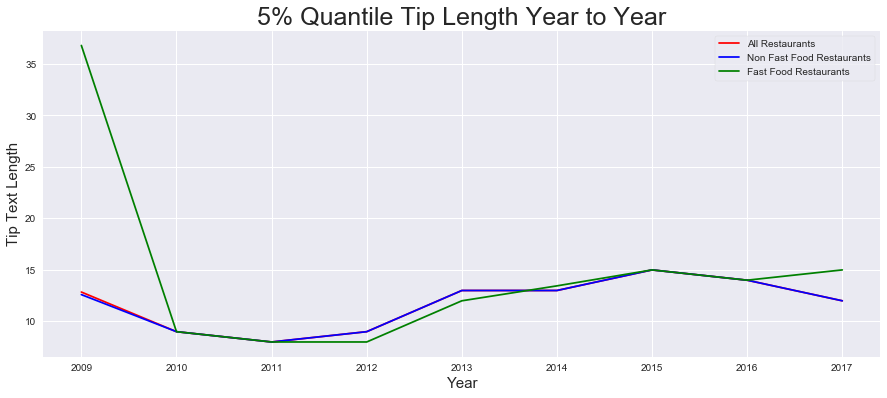

In [8]:
ax = tips_df.groupby(tips_df.date.dt.year).quantile(0.05)['tip_len'].plot(figsize=FIG_SIZE, color='r')
non_fast_food_tips_df.groupby(non_fast_food_tips_df.date.dt.year).quantile(0.05)['tip_len'].plot(ax=ax, color='b')
fast_food_tips_df.groupby(fast_food_tips_df.date.dt.year).quantile(0.05)['tip_len'].plot(ax=ax, color='g')

ax.set_title('5% Quantile Tip Length Year to Year', size=TITLE_FONT_SIZE)
ax.set_xlabel('Year', size=LABEL_FONT_SIZE)
ax.set_ylabel('Tip Text Length', size=LABEL_FONT_SIZE)

ax.set_xticks(tips_df.groupby(tips_df.date.dt.year).quantile(0.05)['tip_len'].index)

ax.legend(['All Restaurants', 'Non Fast Food Restaurants', 'Fast Food Restaurants'], loc=1, frameon=True)

plt.savefig('../charts/tip_length_Q05_yearly.png')
plt.show()
plt.close()

In [9]:
min_tip_len = 5

tips_df_count = tips_df.shape[0]
tips_df = tips_df[tips_df.tip_len >= min_tip_len].copy()
tips_df.reset_index(inplace=True, drop=True)

fast_food_tips_df_count = fast_food_tips_df.shape[0]
fast_food_tips_df = fast_food_tips_df[fast_food_tips_df.tip_len >= min_tip_len].copy()
fast_food_tips_df.reset_index(inplace=True, drop=True)

non_fast_food_tips_df_count = non_fast_food_tips_df.shape[0]
non_fast_food_tips_df = non_fast_food_tips_df[non_fast_food_tips_df.tip_len >= min_tip_len].copy()
non_fast_food_tips_df.reset_index(inplace=True, drop=True)


In [10]:
tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118301 entries, 0 to 118300
Data columns (total 6 columns):
business_id    118301 non-null object
date           118301 non-null datetime64[ns]
likes          118301 non-null int64
text           118301 non-null object
user_id        118301 non-null object
tip_len        118301 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 5.4+ MB


In [11]:
fast_food_tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11941 entries, 0 to 11940
Data columns (total 6 columns):
business_id    11941 non-null object
date           11941 non-null datetime64[ns]
likes          11941 non-null int64
text           11941 non-null object
user_id        11941 non-null object
tip_len        11941 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 559.8+ KB


In [12]:
non_fast_food_tips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106360 entries, 0 to 106359
Data columns (total 6 columns):
business_id    106360 non-null object
date           106360 non-null datetime64[ns]
likes          106360 non-null int64
text           106360 non-null object
user_id        106360 non-null object
tip_len        106360 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 4.9+ MB


In [13]:
print('Reduced {:d} tips to a subset of {:d} tips {:2.4f} [tips_df]'.format(tips_df_count, 
                                                                                        tips_df.shape[0], 
                                                                                        (100.*tips_df.shape[0]/tips_df_count)))
print('Reduced {:d} tips to a subset of {:d} tips {:2.4f} [fast_food_tips_df]'.format(fast_food_tips_df_count, 
                                                                                        fast_food_tips_df.shape[0], 
                                                                                        (100.*fast_food_tips_df.shape[0]/fast_food_tips_df_count)))
print('Reduced {:d} tips to a subset of {:d} tips {:2.4f} [non_fast_food_tips_df]'.format(non_fast_food_tips_df_count, 
                                                                                        non_fast_food_tips_df.shape[0], 
                                                                                        (100.*non_fast_food_tips_df.shape[0]/non_fast_food_tips_df_count)))

Reduced 119274 tips to a subset of 118301 tips 99.1842 [tips_df]
Reduced 12052 tips to a subset of 11941 tips 99.0790 [fast_food_tips_df]
Reduced 107222 tips to a subset of 106360 tips 99.1961 [non_fast_food_tips_df]


# Write to File
<p>Write data frame of only Arizona Restaurant tips to file</p>

In [14]:
file_name = '../clean_data/az_restaurant_tips.csv'
time_marker(text='Writing {:d} records to file {}'.format(tips_df.shape[0], file_name))
tips_df.to_csv(file_name, encoding='utf-8')

file_name = '../clean_data/az_restaurant_fast_food_tips.csv'
time_marker(text='Writing {:d} records to file {}'.format(fast_food_tips_df.shape[0], file_name))
fast_food_tips_df.to_csv(file_name, encoding='utf-8')

file_name = '../clean_data/az_restaurant_non_fast_food_tips.csv'
time_marker(text='Writing {:d} records to file {}'.format(non_fast_food_tips_df.shape[0], file_name))
non_fast_food_tips_df.to_csv(file_name, encoding='utf-8')


time_marker('complete!')

[22:20:30.337067] writing 118301 records to file ../clean_data/az_restaurant_tips.csv
[22:20:33.635580] writing 11941 records to file ../clean_data/az_restaurant_fast_food_tips.csv
[22:20:33.927694] writing 106360 records to file ../clean_data/az_restaurant_non_fast_food_tips.csv
[22:20:36.096253] complete!
